<a href="https://colab.research.google.com/github/vzinkovski/financial-data-science/blob/main/pairs_trading_mean_reversion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Commodities Mean Reversion Trading Strategy

In its most simple form, all trading strategies can be classified as either momentum or mean reversion. Commodities are often fungible which means they can be used as substitutes for each other given the right economics. For such fungible commodity pairs this implies both a positive correlation, as well as cointegration. Cointegration simply means that the individual price series for two commodities cannot deviate indefinitely and will revert to some mean value. This project will explore a mean reverting pairs trading strategy for a select universe of cointegrated commodity pairs. An inherent advantage of restricting our universe to commodities only is that these will be naturally free from survivorship bias.

### Import libraries

In [1]:
# standard libraries
from datetime import datetime, timedelta
import numpy as np
import pandas as pd

# financial analysis
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
from statsmodels.tsa.stattools import adfuller
import yfinance as yf #Yahoo! Finance API

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

### USER INPUT: date range, trading pair, hyperparameters

In [2]:
# date range
start = '2012-01-01' # YYYY-MM-DD format
end = datetime.now() - timedelta(1) # YYYY-MM-DD format

# trading pair
product1_name = 'corn'
product1_ticker = 'ZC=F'
product2_name = 'srw'
product2_ticker = 'ZW=F'

# hyperparameters
lookback = 30 # rolling window for calculating mean and standard deviation
entry_threshold = 2 # Bollinger Bands +/- standard deviation width
exit_threshold = 0 # generate exit signal from long or short to hold
stationarity_alpha = 0.05 # threshold for Augmented Dicky Fuller stationarity test

### Fetch ticker data

In [3]:
def create_pairs_df(product1_name, product1_ticker, product2_name, product2_ticker):

  # fetch data for first product
  data1 = yf.download(product1_ticker, start=start, end=end)
  data1.rename(columns={'Adj Close':product1_name}, inplace=True)

  # fetch data for second product
  data2 = yf.download(product2_ticker, start=start, end=end)
  data2.rename(columns={'Adj Close':product2_name}, inplace=True)

  # create a pairs dataframe
  pairs_df = pd.concat([data1[product1_name], data2[product2_name]], axis=1)
  pairs_df.fillna(method='ffill', inplace=True)

  return pairs_df

pairs_df = create_pairs_df(product1_name, product1_ticker, product2_name, product2_ticker)
pairs_df

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,corn,srw
Date,,
2012-01-03,658.50,657.00
2012-01-04,658.50,650.00
2012-01-05,643.50,629.25
2012-01-06,643.50,624.75
2012-01-09,652.00,641.75
...,...,...
2023-04-17,676.50,696.50
2023-04-18,677.50,698.00
2023-04-19,672.25,681.75


### Calculate spread and Bollinger Bands

In [4]:
def calculate_spread_bbands(pairs_df, product1_name, product2_name, lookback, entry_threshold, exit_threshold):

  # # fit a rolling linear regression between the two products
  # model = RollingOLS(endog=pairs_df.iloc[:,0],
  #                    exog=sm.add_constant(pairs_df.iloc[:,1]),
  #                    window=lookback)
  # rolling_res = model.fit()
  # params = rolling_res.params.copy()

  # # calculate the hedge ratio
  # pairs_df['hedge_ratio'] = params.iloc[:,1]
  # pairs_df.dropna(inplace=True)

  # # calculate the spread and z-score
  # pairs_df['spread'] = pairs_df.iloc[:,0] - pairs_df['hedge_ratio'] * pairs_df.iloc[:,1]
  # pairs_df['zscore'] = (pairs_df['spread'] - np.mean(pairs_df['spread'])) / np.std(pairs_df['spread'])

  # calculating rolling mean and std
  pairs_df['spread'] = pairs_df.iloc[:,0] / pairs_df.iloc[:,1]
  pairs_df['mean'] = pairs_df['spread'].rolling(window=lookback).mean()
  pairs_df['std'] = pairs_df['spread'].rolling(window=lookback).std()
  pairs_df['upper_entry'] = pairs_df['mean'] + entry_threshold * pairs_df['std']
  pairs_df['lower_entry'] = pairs_df['mean'] - entry_threshold * pairs_df['std']
  pairs_df['upper_exit'] = pairs_df['mean'] + exit_threshold * pairs_df['std']
  pairs_df['lower_exit'] = pairs_df['mean'] - exit_threshold * pairs_df['std']

  # # plotting bollinger bands
  # plt.subplots(figsize=(8, 4))
  # plt.plot(pairs_df.index, pairs_df['spread'])
  # plt.plot(pairs_df.index, pairs_df['upper_band'], color='r', linewidth=0.5)
  # plt.plot(pairs_df.index, pairs_df['lower_band'], color='r', linewidth=0.5)
  # plt.title(f'{product1_name} {product2_name} ratio -- BB @ {entry_threshold} std devs')
  # plt.xticks(rotation=45)
  # plt.show()

  return pairs_df

pairs_df = calculate_spread_bbands(pairs_df, product1_name, product2_name, lookback, entry_threshold, exit_threshold)
pairs_df

,corn,srw,spread,mean,std,upper_entry,lower_entry,upper_exit,lower_exit
Date,,,,,,,,,
2012-01-03,658.50,657.00,1.002283,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-04,658.50,650.00,1.013077,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-05,643.50,629.25,1.022646,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-06,643.50,624.75,1.030012,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-09,652.00,641.75,1.015972,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2023-04-17,676.50,696.50,0.971285,0.939978,0.023350,0.986677,0.893279,0.939978,0.939978
2023-04-18,677.50,698.00,0.970630,0.940855,0.024003,0.988862,0.892848,0.940855,0.940855
2023-04-19,672.25,681.75,0.986065,0.942472,0.025369,0.993209,0.891734,0.942472,0.942472


### Test for stationarity

In order to implement a mean reverting strategy we first have to ensure our data is stationary, which simply means a constant mean and variance. A simple test is a quick visual inspection, however a more robust statistical test is the Augmented Dicky-Fuller (ADF) test. A typical $a$ is 0.05 and we reject the null hypothesis when our p-value is below this threshold. In other words, if our p-value is less than $a$ we may conclude that our data is indeed stationary.

In [5]:
def test_stationarity(pairs_df, stationarity_alpha):
    
    result = adfuller(pairs_df['spread'])

    # # print ADF test statistics
    # print('ADF statistic:\n%f' % result[0], '\n')
    # print('p-value: \n%f' % result[1], '\n')
    # print('Critical values:')
    # for key, value in result[4].items():
    #   print('%s @ %.3f' % (key, value))

    if result[1] < stationarity_alpha:
      return (True, pairs_df)
    else:
      return (False, pairs_df)

_, pairs_df = test_stationarity(pairs_df, stationarity_alpha)
pairs_df

,corn,srw,spread,mean,std,upper_entry,lower_entry,upper_exit,lower_exit
Date,,,,,,,,,
2012-01-03,658.50,657.00,1.002283,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-04,658.50,650.00,1.013077,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-05,643.50,629.25,1.022646,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-06,643.50,624.75,1.030012,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-09,652.00,641.75,1.015972,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2023-04-17,676.50,696.50,0.971285,0.939978,0.023350,0.986677,0.893279,0.939978,0.939978
2023-04-18,677.50,698.00,0.970630,0.940855,0.024003,0.988862,0.892848,0.940855,0.940855
2023-04-19,672.25,681.75,0.986065,0.942472,0.025369,0.993209,0.891734,0.942472,0.942472


### Define trading rules

Our base strategy is essentially a Bollinger Bands strategy, which means only a few adjustable hyperparameters, namely the lookback window and standard deviation. Another potential adjustment is whether to use a SMA or EWMA, which we will leave as a future exercise.

In [6]:
def get_trading_signals(pairs_df, product1_name, product2_name):

  pairs_df['signal'] = 0

  # iterating through the time series to determine whether to buy/hold/sell
  # cannot be vectorised as today's trading signal depends on yday's position
  # as such time complexity will be O(N)
  for i in range(1, len(pairs_df)):

    # from hold to sell or buy
    if pairs_df['signal'][i-1] == 0:
      if (pairs_df['spread'][i] < pairs_df['upper_entry'][i]) & (pairs_df['spread'][i-1] >= pairs_df['upper_entry'][i-1]):
        pairs_df.iloc[i, -1] = -1
      elif (pairs_df['spread'][i] > pairs_df['lower_entry'][i]) & (pairs_df['spread'][i-1] <= pairs_df['lower_entry'][i-1]):
        pairs_df.iloc[i, -1] = 1

    # from sell to hold
    elif pairs_df['signal'][i-1] == -1:
      if (pairs_df['spread'][i] < pairs_df['upper_exit'][i]) & (pairs_df['spread'][i-1] >= pairs_df['upper_exit'][i-1]):
        pairs_df.iloc[i, -1] = 0
      else:
        pairs_df.iloc[i, -1] = -1

    # from sell to hold
    elif pairs_df['signal'][i-1] == 1:
      if (pairs_df['spread'][i] > pairs_df['lower_exit'][i]) & (pairs_df['spread'][i-1] <= pairs_df['lower_exit'][i-1]):
        pairs_df.iloc[i, -1] = 0
      else:
        pairs_df.iloc[i, -1] = 1

    else:
      pairs_df.iloc[i, -1] = 0
    
  # pairs_df[f'{product2_name}_signal'] = pairs_df['signal'] * -1
  # pairs_df.rename(columns={'signal':f'{product1_name}_signal'}, inplace=True)

  return pairs_df

pairs_df = get_trading_signals(pairs_df, product1_name, product2_name)

In [7]:
def get_equity_curve(pairs_df, product1_name, product2_name):

  pairs_df[f'{product1_name}_returns'] = pairs_df[product1_name].pct_change()
  pairs_df[f'{product2_name}_returns'] = pairs_df[product2_name].pct_change()
  pairs_df['strategy_returns'] = pairs_df['signal'].shift() * (pairs_df[f'{product1_name}_returns'] - pairs_df[f'{product2_name}_returns'])
  pairs_df['strategy_cumulative_returns'] = (1 + pairs_df['strategy_returns']).cumprod()

  # pairs_df[f'{product1_name}_pnl'] = -1.0 * pairs_df[f'{product1_name}'] * pairs_df['signal']
  # pairs_df[f'{product2_name}_pnl'] = pairs_df[f'{product2_name}'] * pairs_df['signal']
  # pairs_df['total_pnl'] = pairs_df[f'{product1_name}_pnl'] + pairs_df[f'{product2_name}_pnl']
  # pairs_df['returns'] = pairs_df['total_pnl'].pct_change()
  # pairs_df['returns'].fillna(0.0, inplace=True)
  # pairs_df['returns'].replace([np.inf, -np.inf], 0.0, inplace=True)
  # pairs_df['returns'].replace(-1.0, 0.0, inplace=True)
  # pairs_df['returns'] = (pairs_df['returns'] + 1.0).cumprod()

  return pairs_df

pairs_df = get_equity_curve(pairs_df, product1_name, product2_name)
pairs_df

,corn,srw,spread,mean,std,upper_entry,lower_entry,upper_exit,lower_exit,signal,corn_returns,srw_returns,strategy_returns,strategy_cumulative_returns
Date,,,,,,,,,,,,,,
2012-01-03,658.50,657.00,1.002283,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN
2012-01-04,658.50,650.00,1.013077,NaN,NaN,NaN,NaN,NaN,NaN,0,0.000000,-0.010654,0.0,1.000000
2012-01-05,643.50,629.25,1.022646,NaN,NaN,NaN,NaN,NaN,NaN,0,-0.022779,-0.031923,0.0,1.000000
2012-01-06,643.50,624.75,1.030012,NaN,NaN,NaN,NaN,NaN,NaN,0,0.000000,-0.007151,0.0,1.000000
2012-01-09,652.00,641.75,1.015972,NaN,NaN,NaN,NaN,NaN,NaN,0,0.013209,0.027211,-0.0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-17,676.50,696.50,0.971285,0.939978,0.023350,0.986677,0.893279,0.939978,0.939978,0,0.015385,0.020513,-0.0,4.375966
2023-04-18,677.50,698.00,0.970630,0.940855,0.024003,0.988862,0.892848,0.940855,0.940855,0,0.001478,0.002154,-0.0,4.375966
2023-04-19,672.25,681.75,0.986065,0.942472,0.025369,0.993209,0.891734,0.942472,0.942472,0,-0.007749,-0.023281,0.0,4.375966


In [18]:
pairs_df['strategy_cumulative_returns']['2012-03-01':'2012-05-01']

Date
2012-03-01    1.000000
2012-03-02    1.000000
2012-03-05    1.000000
2012-03-06    1.000000
2012-03-07    1.000000
2012-03-08    1.000000
2012-03-09    1.000000
2012-03-12    0.995159
2012-03-13    0.989549
2012-03-14    0.996535
2012-03-15    1.017157
2012-03-16    1.022168
2012-03-19    1.006556
2012-03-20    1.015782
2012-03-21    1.014529
2012-03-22    1.026524
2012-03-23    1.026524
2012-03-26    1.026524
2012-03-27    1.026524
2012-03-28    1.023877
2012-03-29    1.026677
2012-03-30    1.013792
2012-04-02    1.036862
2012-04-03    1.040428
2012-04-04    1.067705
2012-04-05    1.067705
2012-04-09    1.067705
2012-04-10    1.067705
2012-04-11    1.067705
2012-04-12    1.067705
2012-04-13    1.067705
2012-04-16    1.067705
2012-04-17    1.067705
2012-04-18    1.067705
2012-04-19    1.067705
2012-04-20    1.067705
2012-04-23    1.067705
2012-04-24    1.067705
2012-04-25    1.067705
2012-04-26    1.067705
2012-04-27    1.067705
2012-04-30    1.067705
2012-05-01    1.067705
Name: 

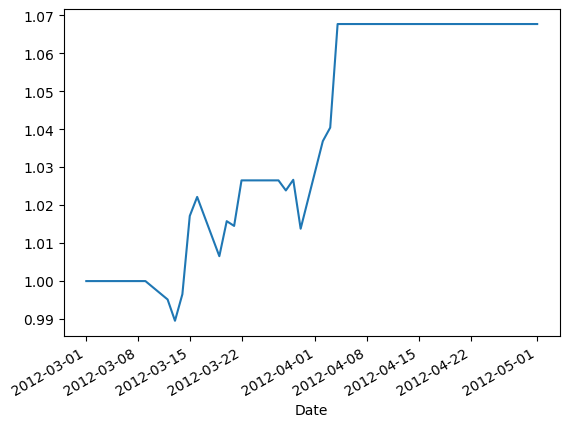

In [19]:
pairs_df['strategy_cumulative_returns']['2012-03-01':'2012-05-01'].plot();

### Commodities pairs universe

In [9]:
pairs_universe = [
            
  # AGRICULTURE

            # corn srw
            {'product1_name':'corn', 
             'product1_ticker':'ZC=F',
             'product2_name':'srw',
             'product2_ticker':'ZW=F'
             },

            # hrw srw
            {'product1_name':'hrw', 
             'product1_ticker':'KE=F',
             'product2_name':'srw',
             'product2_ticker':'ZW=F'
             },

            # soybeans soymeal
            {'product1_name':'soybean', 
             'product1_ticker':'ZS=F',
             'product2_name':'soymeal',
             'product2_ticker':'ZM=F'
             },

            # soybeans soyoil
            {'product1_name':'soybean', 
             'product1_ticker':'ZS=F',
             'product2_name':'soyoil',
             'product2_ticker':'ZL=F'
             },

            # soymeal soyoil
            {'product1_name':'soymeal', 
             'product1_ticker':'ZM=F',
             'product2_name':'soyoil',
             'product2_ticker':'ZL=F'
             },

  # METALS

            # gold silver
            {'product1_name':'gold',
             'product1_ticker':'GC=F',
             'product2_name':'silver',
             'product2_ticker':'SI=F'
             },

            # gold platinum
            {'product1_name':'gold', 
             'product1_ticker':'GC=F',
             'product2_name':'platinum',
             'product2_ticker':'PL=F'
             },

            # silver platinum
            {'product1_name':'silver', 
             'product1_ticker':'SI=F',
             'product2_name':'platinum',
             'product2_ticker':'PL=F'
             },

  # ENERGY

            # brent wti
            {'product1_name':'brent', 
             'product1_ticker':'BZ=F',
             'product2_name':'wti',
             'product2_ticker':'CL=F'
             },
]

In [10]:
def get_portfolio_returns(universe):

  # create empty list of dataframes
  returns = []

  # loop through all pairs in universe
  for pair in universe:
    pairs_df = create_pairs_df(pair['product1_name'], pair['product1_ticker'],
                               pair['product2_name'], pair['product2_ticker'])
    pairs_df = calc_spread_zscore(pairs_df, lookback)
    pairs_df = get_trading_signals(pairs_df, entry_threshold, exit_threshold)
    pairs_returns_df = get_pairs_returns(pairs_df, pair['product1_name'], pair['product2_name'])
    returns.append(pairs_returns_df['returns'])

  # create dataframe from list and calculate mean returns
  returns_df = pd.DataFrame(returns).T
  returns_df['mean_return'] = returns_df.mean(axis=1)

  return returns_df

# END